In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn as nn
import torch.optim as optim
import copy

In [2]:
def combine_gaze_data(root_path="GazeBase_v2_0/Round_1"):
    combined_df = []

    subjects = os.listdir(root_path)
    count = 0
    for subject in subjects:
        try:
            sub_number = subject.split("_")[1]
            file_path = os.path.join(root_path, subject, "S1", "S1_Random_Saccades", f"S_{sub_number}_S1_RAN.csv")

            if os.path.exists(file_path):
                df = pd.read_csv(file_path)
                df['subject_id'] = sub_number  # Add ID column
                df = df[df['x'].notna()]
                combined_df.append(df)
                count+=1
            else:
                print(f"Missing file for {subject}")
        except Exception as e:
            print(f"Error processing {subject}: {e}")
        #if count >= 200:
        #    break

    all_data = pd.concat(combined_df, ignore_index=True)
    return all_data


In [3]:
df = combine_gaze_data()

In [4]:
df

,n,x,y,val,xT,yT,dP,lab,subject_id
0,0,-14.968971,5.085097,0,0.308613,-0.376361,2993.0,0,1201
1,1,-14.971714,5.079250,0,0.308613,-0.376361,2992.0,0,1201
2,2,-14.974457,5.076327,0,0.308613,-0.376361,2990.0,0,1201
3,3,-14.968971,5.073403,0,0.308613,-0.376361,2990.0,0,1201
4,4,-14.960741,5.073403,0,0.308613,-0.376361,2992.0,0,1201
...,...,...,...,...,...,...,...,...,...
31809066,101077,0.279222,-1.413297,0,0.308613,-0.376361,4261.0,1,1275
31809067,101078,0.276283,-1.410352,0,0.308613,-0.376361,4259.0,1,1275
31809068,101079,0.276283,-1.413297,0,0.308613,-0.376361,4257.0,1,1275
31809069,101080,0.276283,-1.422131,0,0.308613,-0.376361,4246.0,1,1275


In [5]:
def split_by_saccades_fixed(df, seq_len=10, step=10):
    inputs = []
    targets = []

    for subject_id, group in df.groupby('subject_id'):
        group = group.reset_index(drop=True)
        positions = group[['x', 'y']].to_numpy()
        labels = group['lab'].to_numpy()
        in_saccade = False
        start_idx = 0

        for i in range(1, len(group)):
            if labels[i] == 2 and not in_saccade:
                in_saccade = True
                start_idx = i
            elif labels[i] != 2 and in_saccade:
                end_idx = i
                in_saccade = False

                saccade_segment = positions[start_idx:end_idx:step]
                if len(saccade_segment) < 3:
                    continue  

                trimmed = saccade_segment[:-2 * int(10/step)] 
                needed = seq_len - len(trimmed)

                if needed > 0:
                    pre_start = max(0, start_idx - needed * step)
                    pre_segment = positions[pre_start:start_idx:step]
                    if len(pre_segment) < needed:
                        continue  
                    padded_traj = np.concatenate([pre_segment[-needed:], trimmed])
                elif len(trimmed) >= seq_len:
                    padded_traj = trimmed[-seq_len:]
                else:
                    continue  # skip if cannot pad and not enough points

                padded_traj = padded_traj 
                landing = positions[end_idx - 1]

                inputs.append(padded_traj)
                targets.append(landing)

    return np.array(inputs, dtype=object), np.array(targets)


In [6]:
saccades, targets = split_by_saccades_fixed(df)

In [7]:
len(saccades)

47126

In [8]:
len(targets)

47126

In [9]:
len(saccades[0])

10

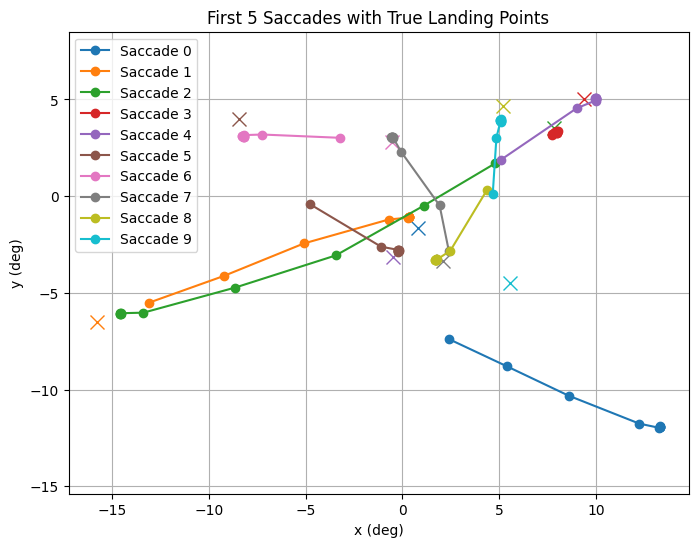

In [10]:
colors = plt.cm.tab10.colors

plt.figure(figsize=(8, 6))

for i in range(10):
    saccade = saccades[i]
    target = targets[i]
    x, y = saccade[:, 0], saccade[:, 1]

    plt.plot(x, y, marker='o', color=colors[i % 10], label=f'Saccade {i}')
    plt.plot(target[0], target[1], marker='x', color=colors[i % 10], markersize=10, linestyle='None')

plt.xlabel('x (deg)')
plt.ylabel('y (deg)')
plt.title('First 5 Saccades with True Landing Points')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()


In [11]:

class SaccadeDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [12]:

class SaccadePredictor(nn.Module):
    def __init__(self, input_size=2, hidden_size=64, num_layers=2):
        super(SaccadePredictor, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 32),  
            nn.ReLU(),
            nn.Linear(32, 2)             
        )

    def forward(self, x):
        out, _ = self.lstm(x)        
        last = out[:, -1, :]         
        pred = self.fc(last)         
        return pred


In [13]:
X, y = split_by_saccades_fixed(df, step=10)
assert all(x.shape == (10, 2) for x in X)

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

X_train_array = np.stack(X_train).astype(np.float32)
X_val_array   = np.stack(X_val).astype(np.float32)
X_test_array  = np.stack(X_test).astype(np.float32)

y_train_array = np.array(y_train, dtype=np.float32)
y_val_array   = np.array(y_val, dtype=np.float32)
y_test_array  = np.array(y_test, dtype=np.float32)


train_dataset = SaccadeDataset(X_train_array, y_train_array)
val_dataset   = SaccadeDataset(X_val_array, y_val_array)
test_dataset  = SaccadeDataset(X_test_array, y_test_array)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [14]:

def euclidean_distance_loss(pred, target):
    return torch.mean(torch.norm(pred - target, dim=1))  # Mean over batch

model = SaccadePredictor()  # Ensure this is defined beforehand
criterion = euclidean_distance_loss  # Use custom loss
optimizer = optim.Adam(model.parameters(), lr=1e-3)

patience = 10
best_loss = float('inf')
best_model_wts = copy.deepcopy(model.state_dict())
epochs_no_improve = 0

for epoch in range(100):
    model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        pred = model(X_batch)
        loss = criterion(pred, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_val, y_val in val_loader:
            val_pred = model(X_val)
            loss_val = criterion(val_pred, y_val)
            val_loss += loss_val.item() * X_val.size(0)
    val_loss /= len(val_loader.dataset)

    print(f"Epoch {epoch+1}, Train Distance: {epoch_loss:.4f}, Val Distance: {val_loss:.4f}")

    if val_loss < best_loss:
        best_loss = val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve == patience:
        print("Early stopping triggered!")
        break

model.load_state_dict(best_model_wts)


Epoch 1, Train Distance: 3.0306, Val Distance: 2.4316
Epoch 2, Train Distance: 2.3511, Val Distance: 2.3906
Epoch 3, Train Distance: 2.2961, Val Distance: 2.3559
Epoch 4, Train Distance: 2.2476, Val Distance: 2.2481
Epoch 5, Train Distance: 2.2232, Val Distance: 2.2482
Epoch 6, Train Distance: 2.1998, Val Distance: 2.2300
Epoch 7, Train Distance: 2.1829, Val Distance: 2.2447
Epoch 8, Train Distance: 2.1746, Val Distance: 2.2280
Epoch 9, Train Distance: 2.1601, Val Distance: 2.2344
Epoch 10, Train Distance: 2.1491, Val Distance: 2.1826
Epoch 11, Train Distance: 2.1382, Val Distance: 2.2301
Epoch 12, Train Distance: 2.1303, Val Distance: 2.2314
Epoch 13, Train Distance: 2.1295, Val Distance: 2.1900
Epoch 14, Train Distance: 2.1159, Val Distance: 2.1836
Epoch 15, Train Distance: 2.1107, Val Distance: 2.1901
Epoch 16, Train Distance: 2.1043, Val Distance: 2.1891
Epoch 17, Train Distance: 2.1016, Val Distance: 2.1942
Epoch 18, Train Distance: 2.0925, Val Distance: 2.1803
Epoch 19, Train Dis

<All keys matched successfully>

In [15]:
model.eval()  
distances = []

def euclidean_distance(pred, target):
    return torch.norm(pred - target, dim=1)

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        preds = model(X_batch)
        batch_dist = euclidean_distance(preds, y_batch)
        distances.append(batch_dist.cpu().numpy())

distances = np.concatenate(distances)
print(f"Average Euclidean distance on test set: {distances.mean():.4f} units")


Average Euclidean distance on test set: 2.0431 units


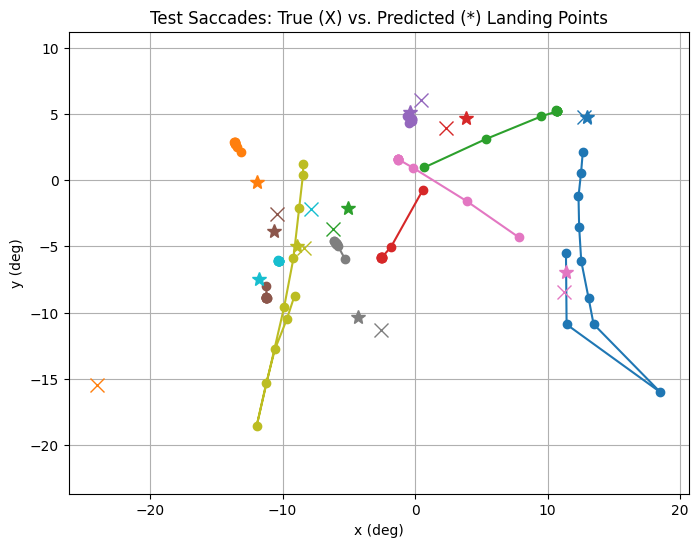

In [16]:
import matplotlib.pyplot as plt
import torch

colors = plt.cm.tab10.colors
model.eval()

plt.figure(figsize=(8, 6))

with torch.no_grad():
    for i, (X_batch, y_batch) in enumerate(test_loader):
        if i >= 2:  
            break
        if i == 1:
            continue

        preds = model(X_batch)

        for j in range(10):
            saccade = X_batch[j].cpu().numpy()
            target = y_batch[j].cpu().numpy()
            pred = preds[j].cpu().numpy()

            x, y = saccade[:, 0], saccade[:, 1]
            color = colors[(i * len(X_batch) + j) % 10]

            plt.plot(x, y, marker='o', color=color, label=f'Saccade {i*len(X_batch)+j}')
            plt.plot(target[0], target[1], marker='x', color=color, markersize=10, linestyle='None')
            plt.plot(pred[0], pred[1], marker='*', color=color, markersize=10, linestyle='None')

plt.xlabel('x (deg)')
plt.ylabel('y (deg)')
plt.title('Test Saccades: True (X) vs. Predicted (*) Landing Points')
plt.grid(True)
plt.axis('equal')
plt.show()
